# Классификация текстов с использованием Наивного Байесовского Классификатора

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Подгрузка данных. Первичный анализ

Узнаем, сколько в данных спам- и не спам-писем. Визуализируем полученные соотношение.

In [3]:
email_data = pd.read_csv("data/spam_or_not_spam.csv")
email_data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
email_data.groupby("label", as_index=False).count()

,label,email
0,0,2500
1,1,499


***0*** - не сам, ***1*** - спам

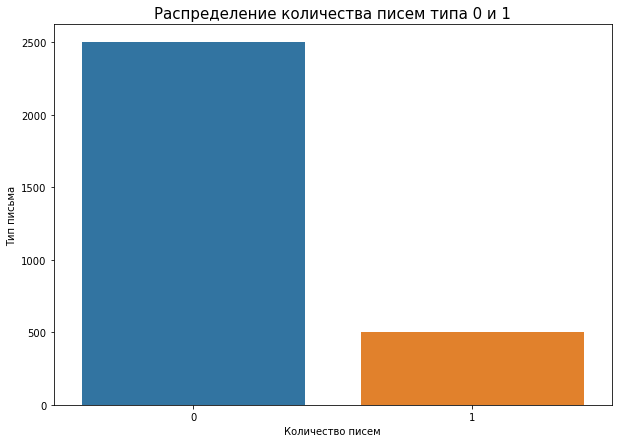

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(data=email_data.groupby("label", as_index=False).count(), x="label", y="email", ax=ax)
ax.set_title("Распределение количества писем типа 0 и 1", fontsize=15)
ax.set_xlabel("Количество писем")
ax.set_ylabel("Тип письма");

Из графика видно, что выборка не сбалансирована.

## Предобработка данных. Приведение их в векторный вид

Подгрузим необходимый модуль:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

Заменим все пустоты в данных на пропуски (NaN). После этого удалим из данных все строки, в которых наблюдаются пропущенные значения.

In [8]:
email_data = email_data.dropna()
email_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   2999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.3+ KB


Переводим данные в векторный вид:

In [9]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(email_data["email"])

Определим, сколько теперь признаков в нашем наборе данных:

In [10]:
X.shape[1]

34116

## Выделение целевой переменной и матрицы признаков

In [11]:
X = X
y = email_data["label"]

Разделим выборку на обучающую и тестовую, размер тестовой выборки возьмём как 0.25:

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Среднее значение целевой переменной по тестовой выборке:

In [199]:
y_test.mean()

0.164

## Обучение модели

В библиотеке **sklearn** есть несколько байесовских классификаторов. Будем использовать **MultinomialNB**, так как он работает с категориальными признаками, текстами и несбалансированными выборками, - наш датасет как раз несбалансирован и столбец *email* - содержит данные категориального типа.

In [13]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_test_pred = mnb.predict(X_test)

Оценим результат на тестовом наборе с точки зрения всех известных метрик:

In [15]:
from sklearn import metrics

print("Accuracy on test data: {:.3f}".format(metrics.accuracy_score(y_test, y_test_pred)))
print("Precision on test data: {:.3f}".format(metrics.precision_score(y_test, y_test_pred)))
print("Recall on test data: {:.3f}".format(metrics.recall_score(y_test, y_test_pred)))
print("f1-score on test data: {:.3f}".format(metrics.f1_score(y_test, y_test_pred)))

Accuracy on test data: 0.996
Precision on test data: 0.992
Recall on test data: 0.984
f1-score on test data: 0.988


In [16]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       627
           1       0.99      0.98      0.99       123

    accuracy                           1.00       750
   macro avg       0.99      0.99      0.99       750
weighted avg       1.00      1.00      1.00       750



Нарисуем ROC-кривую:

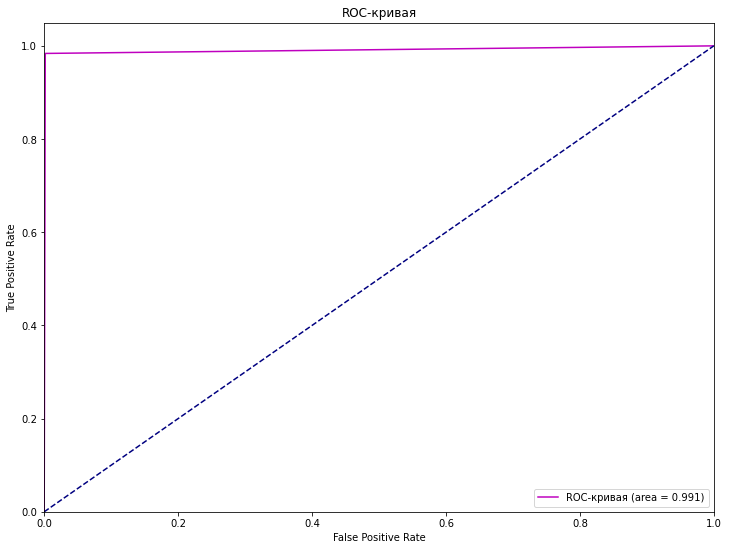

In [17]:
fpr, tpr, treshold = metrics.roc_curve(y_test, y_test_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(12,9))
plt.plot(fpr, tpr, color='m',
         label='ROC-кривая (area = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

## Подбор параметра **alpha** c помощью кросс-валидации

Оценим, зависит ли от этого параметра качество классификации.

In [18]:
from sklearn import model_selection

mnb = MultinomialNB(alpha=0.01)
kf = model_selection.KFold(n_splits=5, shuffle=True)


cv_metrics = model_selection.cross_validate(estimator=mnb, X=X, y=y, cv=kf, scoring="accuracy", return_train_score=True)
display(cv_metrics)

{'fit_time': array([0.00528336, 0.00685072, 0.00864649, 0.00681257, 0.00480056]),
 'score_time': array([0.00177693, 0.00123549, 0.00166488, 0.00148797, 0.00117779]),
 'test_score': array([0.99333333, 0.98666667, 0.99333333, 0.98333333, 0.98831386]),
 'train_score': array([0.9979158 , 0.99833264, 0.9979158 , 0.99708212, 0.99666667])}

In [19]:
mnb = MultinomialNB(alpha=0.05)
cv_metrics = model_selection.cross_validate(estimator=mnb, X=X, y=y, cv=kf, scoring="accuracy", return_train_score=True)
display(cv_metrics)

{'fit_time': array([0.00655603, 0.00543499, 0.00505161, 0.00596523, 0.00425339]),
 'score_time': array([0.00164461, 0.00123286, 0.00109577, 0.00124431, 0.00089312]),
 'test_score': array([0.99166667, 0.99666667, 0.98833333, 0.99333333, 0.98831386]),
 'train_score': array([0.99749896, 0.9958316 , 0.9979158 , 0.99749896, 0.9975    ])}

In [20]:
mnb = MultinomialNB(alpha=0.1)
cv_metrics = model_selection.cross_validate(estimator=mnb, X=X, y=y, cv=kf, scoring="accuracy", return_train_score=True)
display(cv_metrics)

{'fit_time': array([0.00630546, 0.00540924, 0.00521827, 0.00477052, 0.00487757]),
 'score_time': array([0.00126433, 0.00106335, 0.0017283 , 0.00135994, 0.00127101]),
 'test_score': array([0.99      , 0.99666667, 0.98666667, 0.99333333, 0.99165275]),
 'train_score': array([0.99749896, 0.99708212, 0.99666528, 0.99708212, 0.99875   ])}

Как видим, с изменением параметра **alpha** качество классификации изменяется незначительно, хотя параметр сначала был увеличен в **5 раз** до **0.05**, а затем в **10 раз** до **0.1**.